# **M5 Forecasting - Accuracy Competition**

# Table of Contents

- [1. Dataset Overview](#dataset-overview)
- [2. Importing Libraries](#importing-libraries)
- [3. Explanatory Data Analysis (EDA)](#explanatory-data-analysis-eda)
- [4. Data Preprocessing and Feature Engineering](#data-preprocessing-and-feature-engineering)
- [5. Model Training and Evaluation](#model-training-and-evaluation)
- [6. Business Impact Analysis](#business-impact-analysis)

## Dataset Overview

This notebook is based on the dataset provided for the M5 Forecasting Challenge — a competition designed to improve the accuracy of forecasting methods. In this challenge, we aim to predict the daily unit sales of various Walmart products for a 28-day horizon. The dataset includes hierarchical sales data from Walmart stores located in three U.S. states: California, Texas, and Wisconsin.

In addition to sales data, the dataset provides rich contextual features, such as pricing, promotions, calendar information, and special events. This makes it a robust dataset for testing traditional forecasting techniques as well as modern machine learning approaches.

The dataset files include:

- calendar.csv: Contains date-related information, such as holidays and weekdays.
- sales_train_validation.csv: Daily unit sales data per product and store (up to day 1913).
- sales_train_evaluation.csv: Similar to the validation file but also includes data up to day 1941 (used for leaderboard evaluation).
- sell_prices.csv: Lists product prices by store and date.
- sample_submission.csv: Template for submission in the required format.
  
By leveraging this data, we aim to model sales patterns effectively, showcasing methods that can improve inventory planning, reduce waste, and handle forecasting uncertainties with greater precision.

## Importing Libraries

Before we start anything, let's dedicate one cell to importing requirements we will be using throughout the project.

In [6]:
# Warnings
import warnings
from pandas.errors import SettingWithCopyWarning

# Standard libraries
from datetime import datetime
import gc

# Data manipulation and numerical computation
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.fft
from scipy.stats import linregress

# Visualization libraries
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels for time series analysis and statistical modeling
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Scikit-learn modules
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

## Explanatory Data Analysis (EDA)

In this section we will import our datasets, explore every interesting and useful aspect of them and make decisions based on their characteristics.

In [9]:
sales = pd.read_csv(r"C:\Users\user\Desktop\sales_train_validation.csv")
calendar = pd.read_csv(r"C:\Users\user\Desktop\calendar.csv")
prices = pd.read_csv(r"C:\Users\user\Desktop\sell_prices.csv")
submission = pd.read_csv(r"C:\Users\user\Desktop\sample_submission.csv")

In [10]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [11]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [12]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [13]:
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since we imported all of them, let's investigate all the categories that we might group our data on, and create different kinds of time series.

In [15]:
sales['state_id'].unique()

array(['CA', 'TX', 'WI'], dtype=object)

In [16]:
sales['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

In [17]:
prices['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In addition to various secondary features, our dataset includes key primary features that define the structure of the data and establish multiple hierarchical levels within the time serieIn addition to various secondary features, our dataset includes key primary features that define the structure of the data and establish multiple hierarchical levels within the time series.

In [19]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


Before we do some further analyses, we have to somehow make our data more efficient. Because of the high dimensions and number of instances it is good practice to downcast the datasets for faster and less computational coding process.

In [21]:
def memory_usage_mb(df):
    return df.memory_usage(deep=True).sum() / 1024**2
sales_copy = sales.copy()
prices_copy = prices.copy()
calendar_copy = calendar.copy()

mem_before = {
    'sales': memory_usage_mb(sales_copy),
    'prices': memory_usage_mb(prices_copy),
    'calendar': memory_usage_mb(calendar_copy)
}

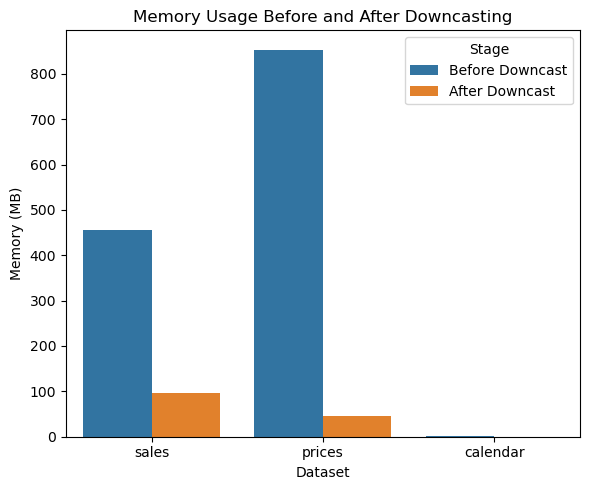

In [22]:
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

mem_after = {
    'sales': memory_usage_mb(sales),
    'prices': memory_usage_mb(prices),
    'calendar': memory_usage_mb(calendar)
}

df_plot = pd.DataFrame({
    'Dataset': list(mem_before.keys()) + list(mem_after.keys()),
    'Memory (MB)': list(mem_before.values()) + list(mem_after.values()),
    'Stage': ['Before Downcast'] * len(mem_before) + ['After Downcast'] * len(mem_after)
})

plt.figure(figsize=(6, 5))
sns.barplot(data=df_plot, x='Dataset', y='Memory (MB)', hue='Stage')

plt.title('Memory Usage Before and After Downcasting')
plt.ylabel('Memory (MB)')
plt.tight_layout()
plt.show()

Just like that, all of our datasets now have much less memory usage, which will fasten things up. Calendar dataset did not have much of a memory usage before, but the other two showed significantly high downcasting of the memory, which is what we intended.

One more thing before we continue with EDA, we have three separate dataset, which is not really convinient, so I will use melt to convert our sales data from wide to long format and then merge the other ones to it.

In [25]:
prices["id"] = prices["item_id"].astype(str) + "_" + prices["store_id"].astype(str) + "_validation"

In [26]:
prices = pd.concat([prices, prices["item_id"].str.split("_", expand=True)], axis=1)

prices = prices.rename(columns={0: "cat_id", 1: "dept_id"})

prices[["store_id", "item_id", "cat_id", "dept_id"]] = prices[["store_id", "item_id", "cat_id", "dept_id"]].astype("category")

prices = prices.drop(columns=2)

In [27]:
def make_dataframe():
    df_wide_train = sales.drop(columns=["item_id", "dept_id", "cat_id", "state_id", "store_id", "id"]).T
    df_wide_train.index = calendar["date"][:1913]
    df_wide_train.columns = sales["id"]
    
    df_wide_test = pd.DataFrame(
        np.zeros(shape=(56, len(df_wide_train.columns))),
        index=calendar["date"][1913:],
        columns=df_wide_train.columns
    )
    
    df_wide = pd.concat([df_wide_train, df_wide_test])
    df_long = df_wide.stack().reset_index(1)
    df_long.columns = ["id", "value"]
    
    sales_df = pd.merge(pd.merge(df_long.reset_index(), calendar, on="date"), prices, on=["id", "wm_yr_wk"])
    sales_df = sales_df.drop(columns=["d"])
    sales_df["sell_price"] = sales_df["sell_price"].astype("float16")   
    sales_df["value"] = sales_df["value"].astype("int32")
    sales_df["state_id"] = sales_df["store_id"].str[:2].astype("category")

    return sales_df

df = make_dataframe()

In [28]:
df.head()

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,event_type_2,snap_CA,snap_TX,snap_WI,store_id,item_id,sell_price,cat_id,dept_id,state_id
0,2011-01-29,HOBBIES_1_008_CA_1_validation,12,11101,Saturday,1,1,2011,NaN,NaN,...,NaN,0,0,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA
1,2011-01-29,HOBBIES_1_009_CA_1_validation,2,11101,Saturday,1,1,2011,NaN,NaN,...,NaN,0,0,0,CA_1,HOBBIES_1_009,1.559570,HOBBIES,1,CA
2,2011-01-29,HOBBIES_1_010_CA_1_validation,0,11101,Saturday,1,1,2011,NaN,NaN,...,NaN,0,0,0,CA_1,HOBBIES_1_010,3.169922,HOBBIES,1,CA
3,2011-01-29,HOBBIES_1_012_CA_1_validation,0,11101,Saturday,1,1,2011,NaN,NaN,...,NaN,0,0,0,CA_1,HOBBIES_1_012,5.980469,HOBBIES,1,CA
4,2011-01-29,HOBBIES_1_015_CA_1_validation,4,11101,Saturday,1,1,2011,NaN,NaN,...,NaN,0,0,0,CA_1,HOBBIES_1_015,0.700195,HOBBIES,1,CA


Done! Now let's analyze our final product.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47735397 entries, 0 to 47735396
Data columns (total 21 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   id            object        
 2   value         int32         
 3   wm_yr_wk      int16         
 4   weekday       category      
 5   wday          int8          
 6   month         int8          
 7   year          int16         
 8   event_name_1  category      
 9   event_type_1  category      
 10  event_name_2  category      
 11  event_type_2  category      
 12  snap_CA       int8          
 13  snap_TX       int8          
 14  snap_WI       int8          
 15  store_id      category      
 16  item_id       category      
 17  sell_price    float16       
 18  cat_id        category      
 19  dept_id       category      
 20  state_id      category      
dtypes: category(10), datetime64[ns](1), float16(1), int16(2), int32(1), int8(5), object(1)
memory usag

In [31]:
df.isna().sum()

date                   0
id                     0
value                  0
wm_yr_wk               0
weekday                0
wday                   0
month                  0
year                   0
event_name_1    43805087
event_type_1    43805087
event_name_2    47610424
event_type_2    47610424
snap_CA                0
snap_TX                0
snap_WI                0
store_id               0
item_id                0
sell_price             0
cat_id                 0
dept_id                0
state_id               0
dtype: int64

Everything seems alright, we don't have any extra ambigous null values. Those event features are suppose to have NaNs, because they only show the days where some event happened, and NaNs show just regular days.  

Let's add some date features, cause we might need them for some plots.

In [33]:
def add_date_feature(df):
    df["year"] = df["date"].dt.year.astype("int16")
    df["month"] = df["date"].dt.month.astype("int8")
    df["week"] = df["date"].dt.isocalendar().week.astype("int8")
    df["day"] = df["date"].dt.day.astype("int8")
    df["quarter"]  = df["date"].dt.quarter.astype("int8")
    return df
df = add_date_feature(df)

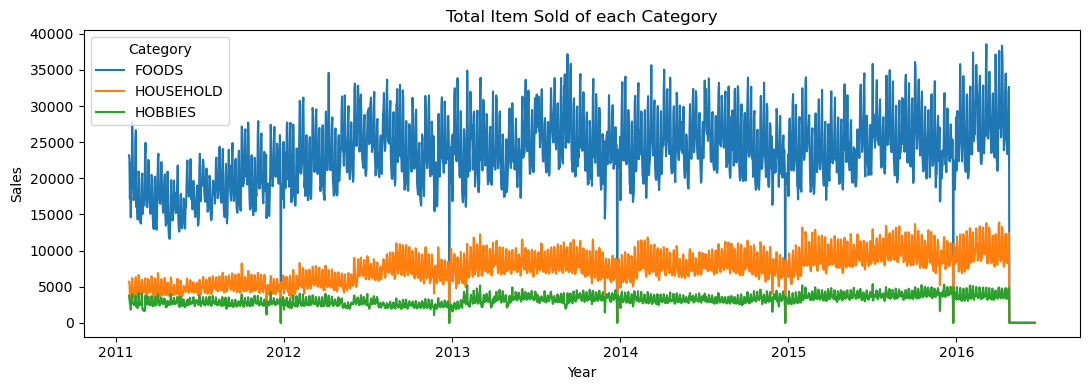

In [34]:
warnings.simplefilter(action='ignore', category=FutureWarning)

temp_series = df.groupby(["cat_id", "date"])["value"].sum()

categories = ["FOODS", "HOUSEHOLD", "HOBBIES"]

plt.figure(figsize=(11, 4))

for cat in categories:
    filtered = temp_series[temp_series.index.get_level_values("cat_id") == cat]
    dates = filtered.index.get_level_values("date")
    values = filtered.values
    plt.plot(dates, values, label=cat)

plt.title("Total Item Sold of each Category")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend(title="Category")
plt.tight_layout()
plt.show()

Accodring to these graph, FOODS is the most sold category, followed by HOUSEHOLD, with HOBBIES being the least. FOODS appears to have seasonal trends, more sales in summer than winter. Short-term patterns may also exist monthly or weekly. 

HOUSEHOLD sales show a gradual increase from 2011, possibly due to new items being added over time. Periodic trends are less clear than in FOODS, so we should account for the total number of items in-store. HOBBIES also show weak seasonality, similar to HOUSEHOLD.

Notably, all categories show a drop in sales around year-end, which might be because of the holiday period, let's plot more zoomed version to check it out.

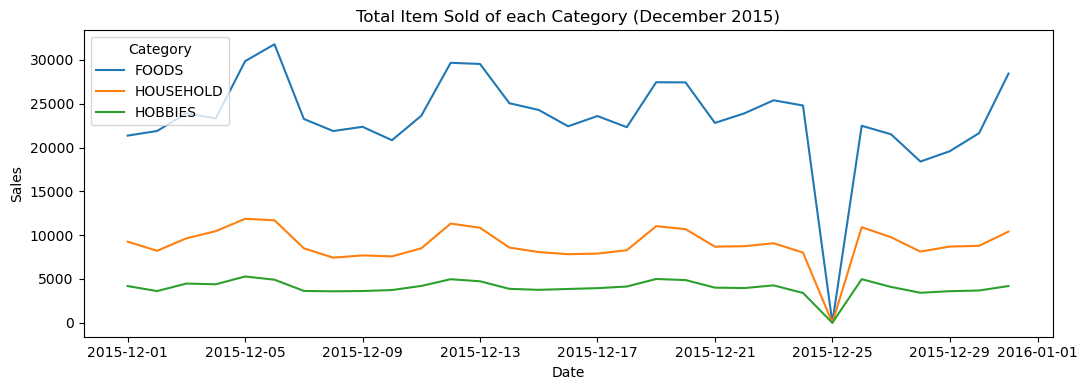

In [36]:
warnings.simplefilter(action='ignore', category=FutureWarning)

temp_series = df.groupby(["cat_id", "date"])["value"].sum()

december_2015 = (temp_series.index.get_level_values("date") >= "2015-12-01") & \
                (temp_series.index.get_level_values("date") <= "2015-12-31")
temp_series = temp_series[december_2015]

categories = ["FOODS", "HOUSEHOLD", "HOBBIES"]

plt.figure(figsize=(11, 4))

for cat in categories:
    filtered = temp_series[temp_series.index.get_level_values("cat_id") == cat]
    dates = filtered.index.get_level_values("date")
    values = filtered.values
    plt.plot(dates, values, label=cat)

plt.title("Total Item Sold of each Category (December 2015)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(title="Category", loc='upper left')
plt.tight_layout()
plt.show()

As expected, the drop is on every 25th of December, which is Christmas in the USA, so the sales of every store drops to 0, because they are closed.

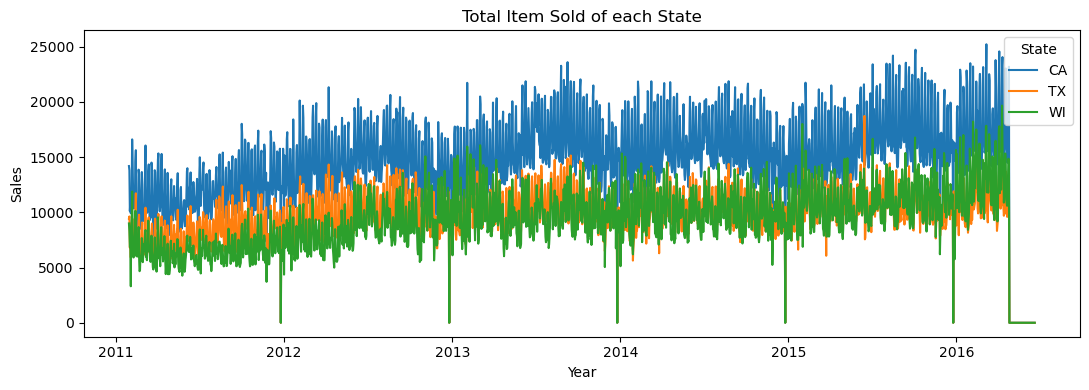

In [38]:
warnings.simplefilter(action='ignore', category=FutureWarning)

temp_series = df.groupby(["state_id", "date"])["value"].sum()

states = ["CA", "TX", "WI"]

plt.figure(figsize=(11, 4))

for state in states:
    filtered = temp_series[temp_series.index.get_level_values("state_id") == state]
    dates = filtered.index.get_level_values("date")
    values = filtered.values
    plt.plot(dates, values, label=state)

plt.title("Total Item Sold of each State")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend(title="State", loc='upper right')
plt.tight_layout()
plt.show()

This graph shows sales of each state. We can tell that California's stores have the highest sales, which is probably because of higher number of stores there. Texas and Wisconsin have roughly the same amount of sales and patterns over time. As we already mentioned, we still have some sales drops at the end of the every year, because of the holiday season. California's sales also show greater fluctuations, possibly due to a more diverse customer base, wider product assortment, or regional promotions that impact demand more strongly.

Now let's check each store for every state - their time series.

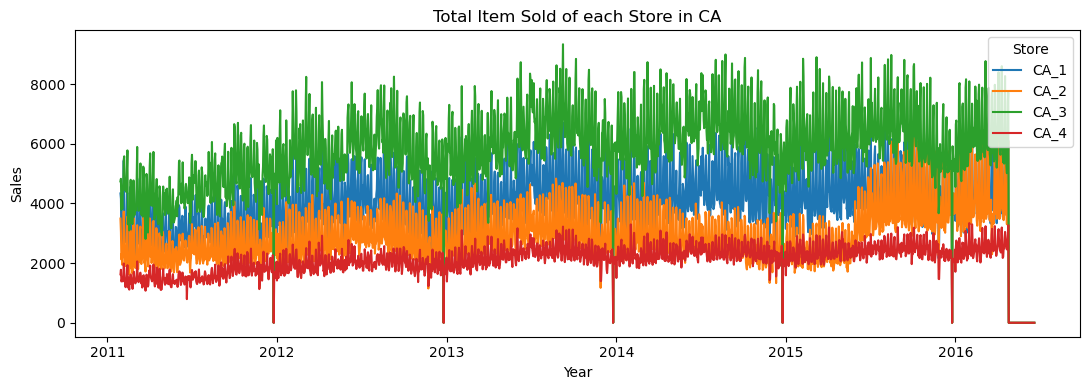

In [41]:
warnings.simplefilter(action='ignore', category=FutureWarning)

temp_series = df.groupby(["store_id", "date"])["value"].sum()

ca_stores = ["CA_1", "CA_2", "CA_3", "CA_4"]

plt.figure(figsize=(11, 4))

for store in ca_stores:
    filtered = temp_series[temp_series.index.get_level_values("store_id") == store]
    dates = filtered.index.get_level_values("date")
    values = filtered.values
    plt.plot(dates, values, label=store)

plt.title("Total Item Sold of each Store in CA")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend(title="Store", loc='upper right')
plt.tight_layout()
plt.show()

This time series show that 3rd store consistently has the highest sales among the four stores, followed by 1st, 2nd and 4th branches in California.

All stores show a strong seasonality, with slight yearly seasonality, like the other hierarchies we investigated so far, which is because of the seasons and the sales correlation. We still have the same drops for each store at the end of the each year and slight upwards trend in each store's sales.

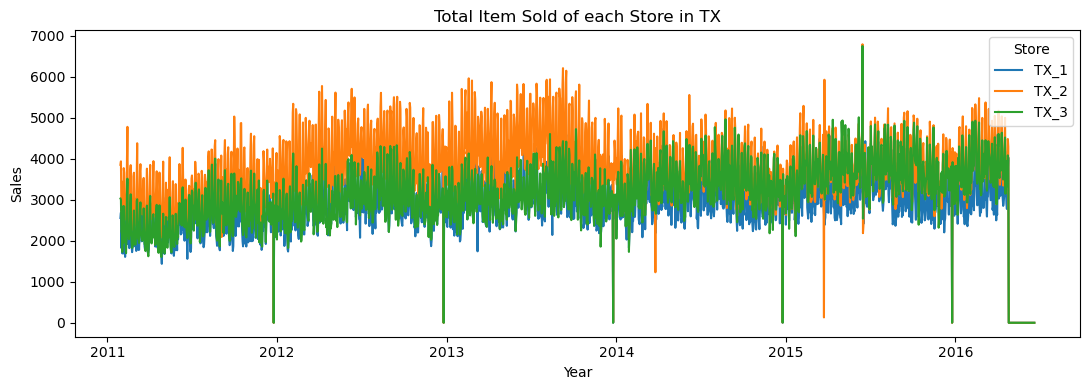

In [43]:
tx_stores = ["TX_1", "TX_2", "TX_3"]

plt.figure(figsize=(11, 4))

for store in tx_stores:
    filtered = temp_series[temp_series.index.get_level_values("store_id") == store]
    dates = filtered.index.get_level_values("date")
    values = filtered.values
    plt.plot(dates, values, label=store)

plt.title("Total Item Sold of each Store in TX")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend(title="Store", loc='upper right')
plt.tight_layout()
plt.show()

We have pretty much the same pattern, trend and seasonality in Texas too, with 2nd store having the highest number of sales at the begining, but then it stabilizes and becomes around the same amount as the 3rd store, while the 1st one having, just a little bit lower sales amount throughout the whole observation period. All of them have the same seasonality, seasonal and weekly, like other previous plots and really slight upward trend.

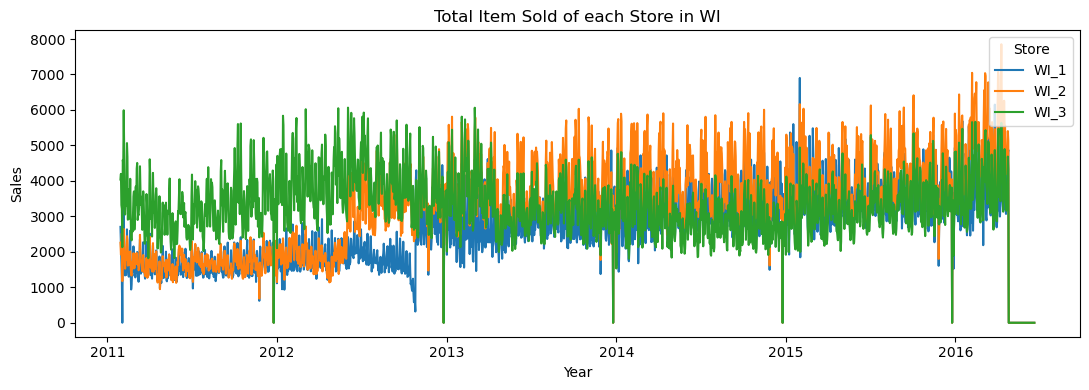

In [45]:
wi_stores = ["WI_1", "WI_2", "WI_3"]

plt.figure(figsize=(11, 4))

for store in wi_stores:
    filtered = temp_series[temp_series.index.get_level_values("store_id") == store]
    dates = filtered.index.get_level_values("date")
    values = filtered.values
    plt.plot(dates, values, label=store)

plt.title("Total Item Sold of each Store in WI")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend(title="Store", loc='upper right')
plt.tight_layout()
plt.show()

In Wisconsin, the 3rd store does not show any noticeable trend, its sales remain relatively stable with consistent seasonality over time, similar to previous patterns. In contrast, the 1st and 2nd stores start with small fluctuations, but both experience sharp increases in sales at different points, likely due to specific events. After these jumps, their sales stay significantly higher and show greater fluctuations.

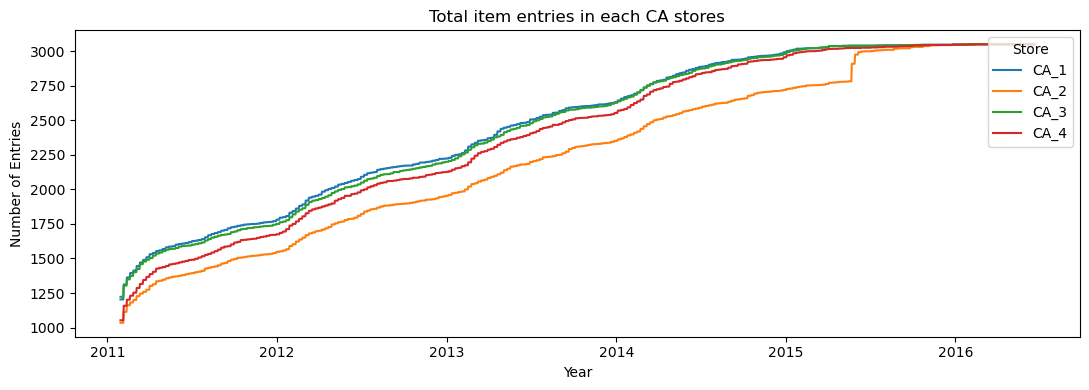

In [47]:
warnings.simplefilter(action='ignore', category=FutureWarning)
temp_series = df.groupby(["store_id", "date"])["item_id"].count()

stores = ["CA_1", "CA_2", "CA_3", "CA_4"]

plt.figure(figsize=(11, 4))

for store in stores:
    filtered = temp_series[temp_series.index.get_level_values("store_id") == store]
    dates = filtered.index.get_level_values("date")
    values = filtered.values
    plt.plot(dates, values, label=store)

plt.title("Total item entries in each CA stores")
plt.xlabel("Year")
plt.ylabel("Number of Entries")
plt.legend(title="Store", loc='upper right')
plt.tight_layout()
plt.show()

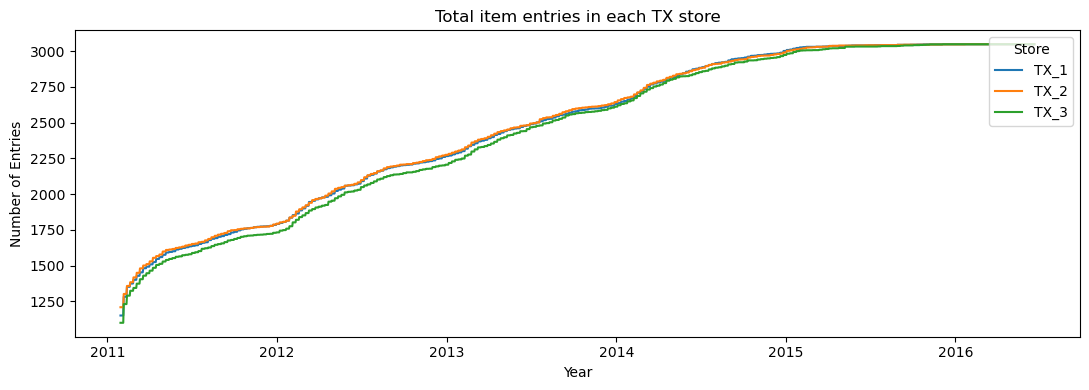

In [48]:
tx_stores = ["TX_1", "TX_2", "TX_3"]

plt.figure(figsize=(11, 4))

for store in tx_stores:
    filtered = temp_series[temp_series.index.get_level_values("store_id") == store]
    dates = filtered.index.get_level_values("date")
    values = filtered.values
    plt.plot(dates, values, label=store)

plt.title("Total item entries in each TX store")
plt.xlabel("Year")
plt.ylabel("Number of Entries")
plt.legend(title="Store", loc='upper right')
plt.tight_layout()
plt.show()

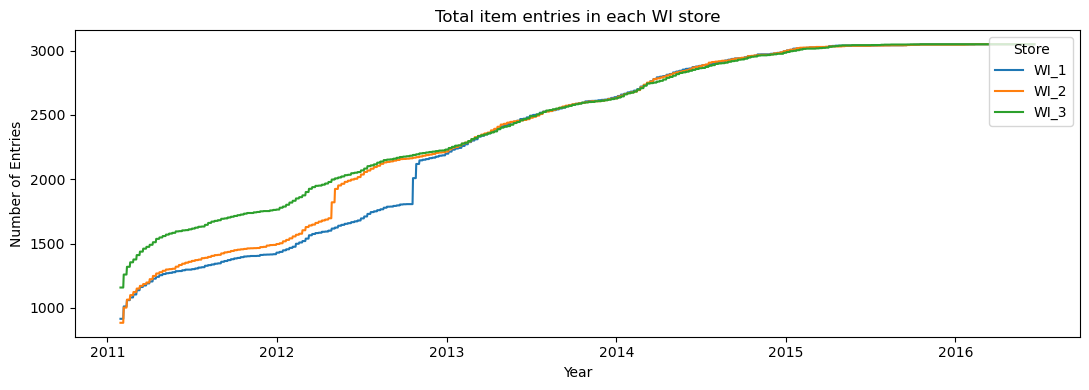

In [49]:
wi_stores = ["WI_1", "WI_2", "WI_3"]

plt.figure(figsize=(11, 4))

for store in wi_stores:
    filtered = temp_series[temp_series.index.get_level_values("store_id") == store]
    dates = filtered.index.get_level_values("date")
    values = filtered.values
    plt.plot(dates, values, label=store)

plt.title("Total item entries in each WI store")
plt.xlabel("Year")
plt.ylabel("Number of Entries")
plt.legend(title="Store", loc='upper right')
plt.tight_layout()
plt.show()

All three plots for each state of entry time series, we have pretty much the same results, having significantly increasing trend of available items in each state's each store. All of them merge gradually, and at the end of the observation period reach the 3K peak. Texas store varied the lest, all of them every already merged, meaning that number of available items in each store were the same, unlike in other two states, were they varied in early periods. 

These entry trends match exactly with the previously observed stores' sales graphs, for example the 1st store of Wisonsin here has a huge jump in number of entries at the end of the 2013, which exactly matches the time where the sales jumped, as well as jump of 2nd store's entries and sales, they also match. This is pretty logical, which makes us assume that higher variability of the entries in stores, made their sales go high in a short period of time.

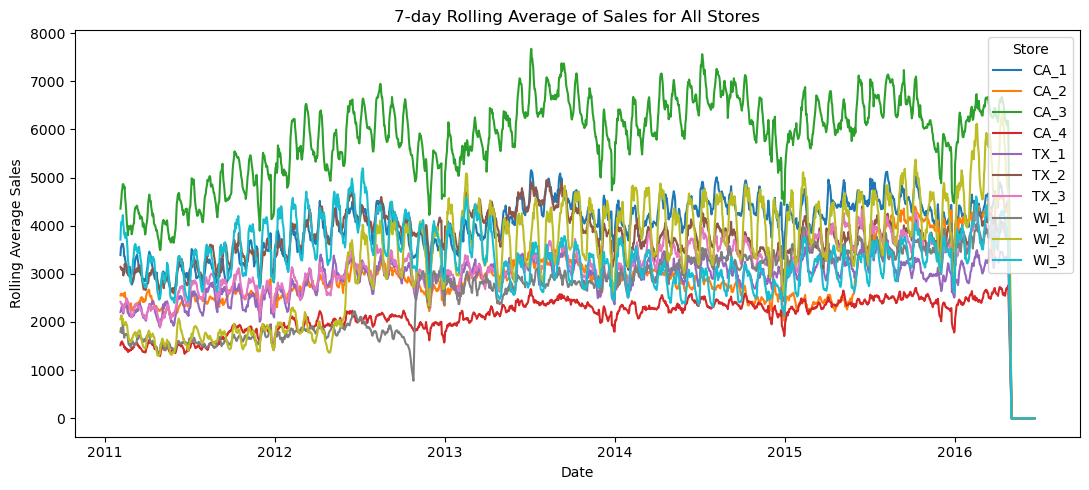

In [51]:
warnings.simplefilter(action='ignore', category=FutureWarning)

temp_series = df.groupby(["store_id", "date"])["value"].sum()

all_stores = temp_series.index.get_level_values("store_id").unique()

plt.figure(figsize=(11, 5))

for store in all_stores:
    filtered = temp_series[temp_series.index.get_level_values("store_id") == store]
    filtered = filtered.sort_index(level="date")
    rolling_avg = filtered.rolling(window=7).mean()

    plt.plot(rolling_avg.index.get_level_values("date"), rolling_avg.values, label=store)

plt.title("7-day Rolling Average of Sales for All Stores")
plt.xlabel("Date")
plt.ylabel("Rolling Average Sales")
plt.legend(title="Store", loc='upper right')
plt.tight_layout()
plt.show()

This plot shows a less noisy version of all sales time series across the states, helping us to check them out and make clearer comparisons. California's 3rd store starts and ends with a strong advantage in sales amount across the whole series, whilst the 4th store shows the lest amount of sales with Wisconsin's 1st and 2nd stores before mid 2012s, when they both have a huge jump as we've already seen and the California's 4th store stays at the bottom with the least amount of sales.

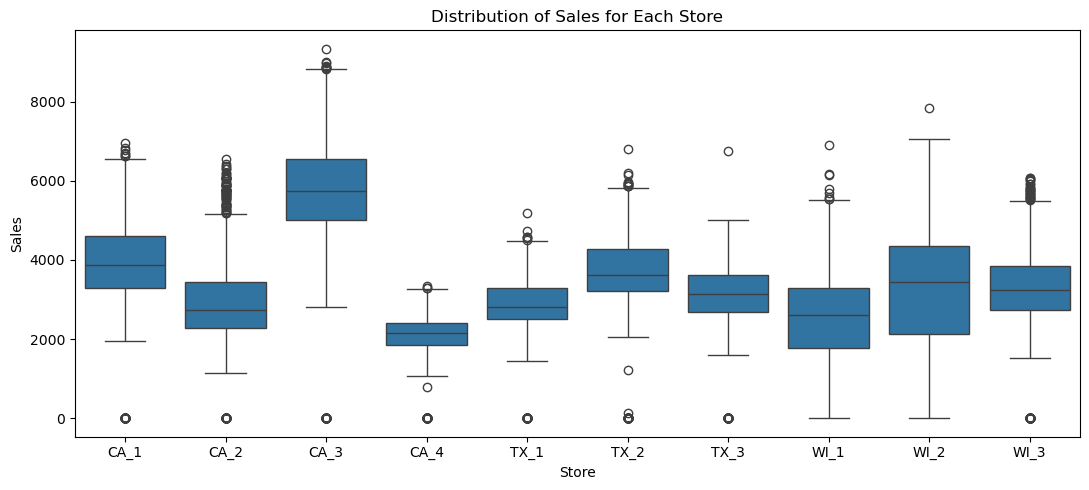

In [53]:
warnings.simplefilter(action='ignore', category=FutureWarning)

temp_df = df.groupby(["store_id", "date"])["value"].sum().reset_index()

plt.figure(figsize=(11, 5))
sns.boxplot(data=temp_df, x="store_id", y="value")

plt.title("Distribution of Sales for Each Store")
plt.xlabel("Store")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

This box plot tell us that pretty much all of the stores sales data shows lots of high outliers, more than the lower ones. This was also shown on the time series plots via spike that we had on each time series. Since we have different event dummy variables, we can keep these outliers, because those columns will make our models able to learn from them, rather than just sabotage the training process. All of them have the moderate distributions, but we should note two following stores: California's 4th with the smalles, and Wisconsin's 2nd with the notably highest variability. 

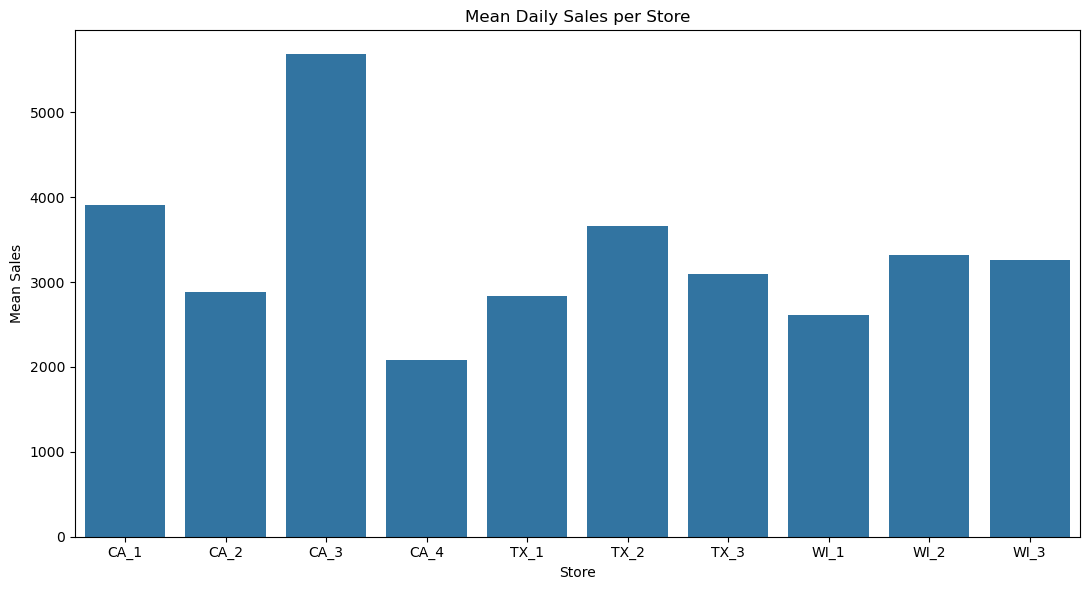

In [55]:
daily_sales = df.groupby(["store_id", "date"])["value"].sum().reset_index()

mean_sales = daily_sales.groupby("store_id")["value"].mean().reset_index()

plt.figure(figsize=(11, 6))
sns.barplot(data=mean_sales, x="store_id", y="value", ci=None)

plt.title("Mean Daily Sales per Store")
plt.xlabel("Store")
plt.ylabel("Mean Sales")
plt.legend([], [], frameon=False) 

plt.tight_layout()
plt.show()

The bar plot provides an overview of mean daily sales across stores in three states, which gives us a closer look than the box plot medians. California's 3rd store has the highest mean sales among all stores, while the 1st store has moderate sales, followed by 2nd and 4th one. Texas's 2nd store leads in mean sales within Texas, followed by 3rd and 1st stores. Wisconsin's 2nd store and Wisconsin's 3rd store show similar sales, performing better than 1st one. Overall, California's 3rd store significantly outperforms the rest.

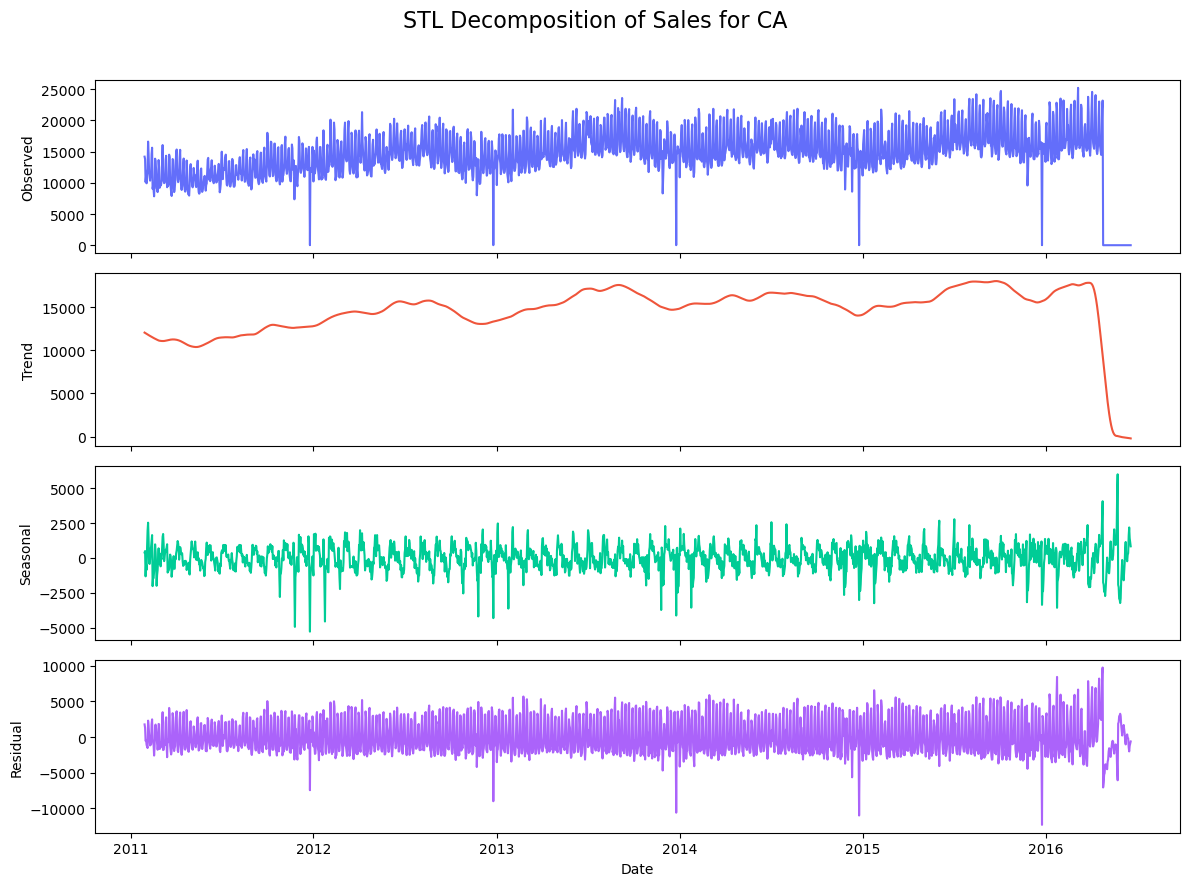

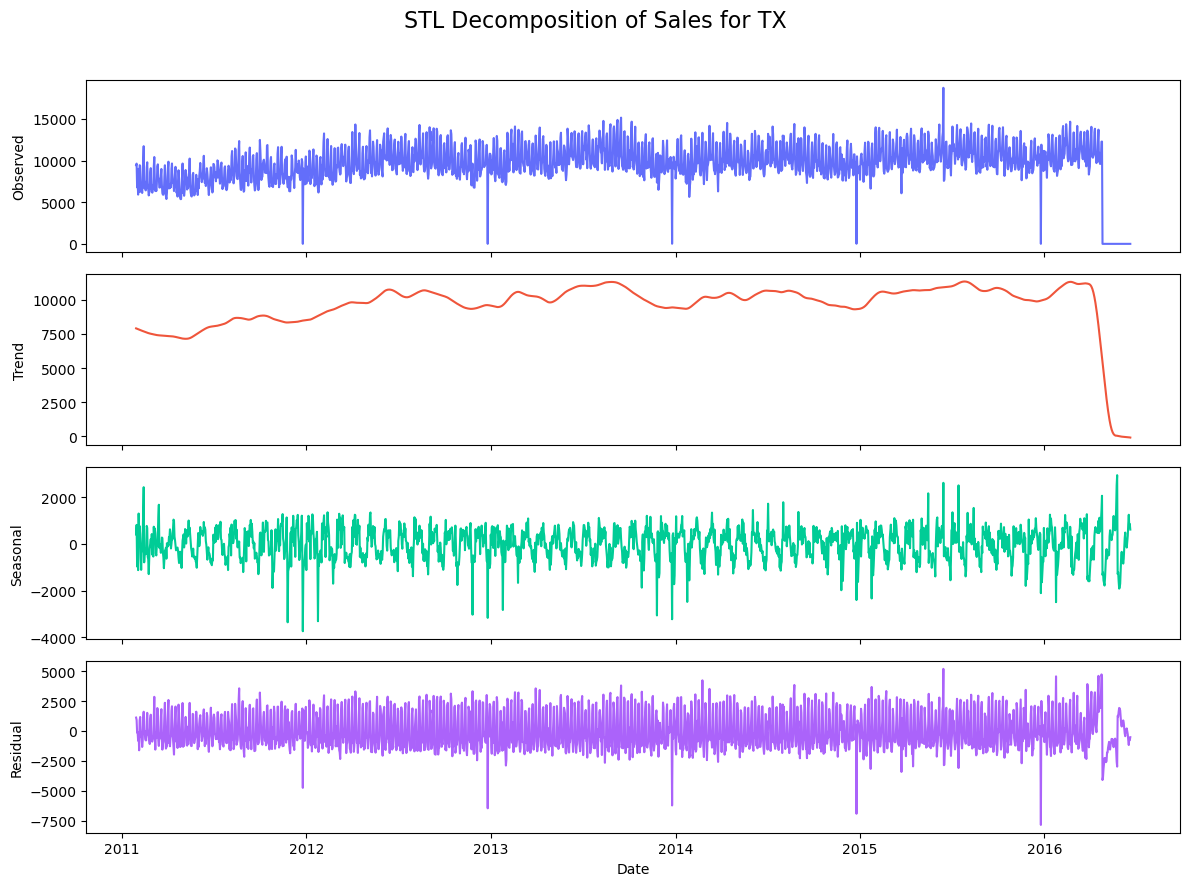

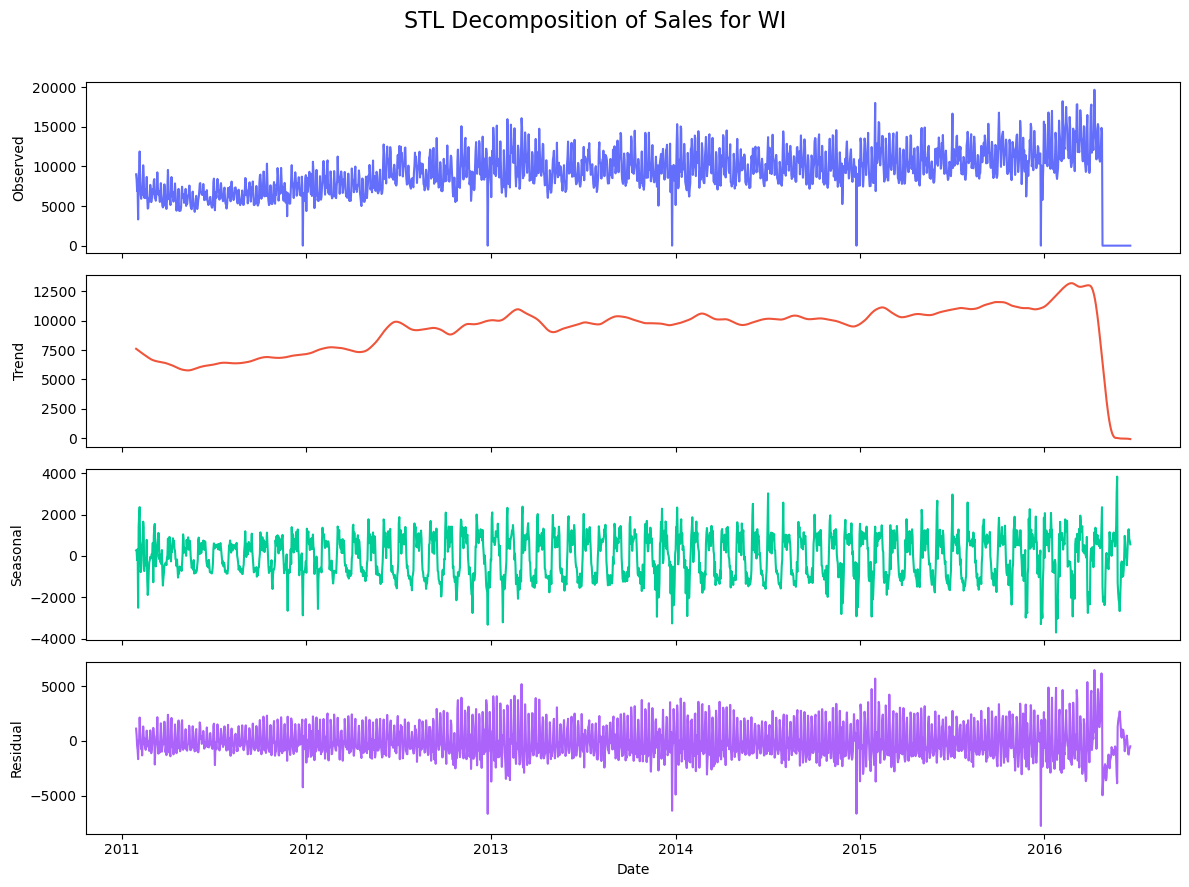

In [57]:
state_sales = df.groupby(["state_id", "date"])["value"].sum().reset_index()
states = state_sales["state_id"].unique()

colors = {
    "Observed": '#636EFA',
    "Trend": '#EF553B',
    "Seasonal": '#00CC96',
    "Residual": '#AB63FA'
}

for state in states:
    temp = state_sales[state_sales["state_id"] == state]
    ts = temp.set_index("date")["value"].asfreq("D").fillna(0)

    stl = STL(ts, period=30)
    result = stl.fit()

    fig, axs = plt.subplots(4, 1, figsize=(12, 9), sharex=True)
    fig.suptitle(f"STL Decomposition of Sales for {state}", fontsize=16)

    axs[0].plot(ts.index, ts.values, color=colors["Observed"])
    axs[0].set_ylabel("Observed")

    axs[1].plot(ts.index, result.trend, color=colors["Trend"])
    axs[1].set_ylabel("Trend")

    axs[2].plot(ts.index, result.seasonal, color=colors["Seasonal"])
    axs[2].set_ylabel("Seasonal")

    axs[3].plot(ts.index, result.resid, color=colors["Residual"])
    axs[3].set_ylabel("Residual")
    axs[3].set_xlabel("Date")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()

All these decomposed series show the similar trend and seasonality as we have observed in the regular time series plots. Trend component for each store shows a little ups and downs, but overall upward shape across 5 years. Seasonality component shows high fluctuations, gives us approximately weekly seasonality for each state. Residuals are really fluctuative, indicating highly noisy data.

Let's now check the stationarity of each notable hierarchy that we have observed so fat.

In [60]:
state_sales = df.groupby(['state_id', 'date'])['value'].sum().reset_index()

results = []

for state, group in state_sales.groupby('state_id'):
    ts = group.set_index('date')['value'].asfreq('D').fillna(0)
    
    adf_result = adfuller(ts)
    p_value = adf_result[1]
    test_stat = adf_result[0]
    
    results.append({
        'state_id': state,
        'adf_test_stat': test_stat,
        'adf_p_value': p_value,
        'stationary': p_value < 0.05 
    })

stationarity_df = pd.DataFrame(results)
print(stationarity_df)

  state_id  adf_test_stat  adf_p_value  stationary
0       CA      -0.699962     0.846759       False
1       TX      -0.158279     0.943315       False
2       WI      -0.680934     0.851626       False


In [61]:
category_sales = df.groupby(['cat_id', 'date'])['value'].sum().reset_index()

results = []

for cat, group in category_sales.groupby('cat_id'):
    ts = group.set_index('date')['value'].asfreq('D').fillna(0)
    
    adf_result = adfuller(ts)
    p_value = adf_result[1]
    test_stat = adf_result[0]
    
    results.append({
        'cat_id': cat,
        'adf_test_stat': test_stat,
        'adf_p_value': p_value,
        'stationary': p_value < 0.05
    })

stationarity_df = pd.DataFrame(results)
print(stationarity_df)

      cat_id  adf_test_stat  adf_p_value  stationary
0      FOODS       0.265759     0.975718       False
1    HOBBIES      -1.541291     0.512996       False
2  HOUSEHOLD      -1.833811     0.363809       False


Not surprisingly, not even a single grouped version of our sales data showed stationary times series, which tells us that using any kinds of traditional forecasting models on our dataset would be nonsense. Because of the ambigous patterns and high noise, without a single stationary series, only appropriate approach for this data is feature-based regression. 

I will stick to the regression approach and use 2 types of tree-based models:

**Random Forest** - As our baseline model, pretty simple yet strong model for regression task, little bit slower, but good way to set a good example results for advanced model, and comparison.

**LightGBM** - As the main model. It is a really strong boosting method for our task, showing the highest accuracy according to other competition participants. It also is much faster than the other models, making it the great match for our dataset.

## Data Preprocessing and Feature Engineering

In this section, I will forget the dataframe I created for an EDA and start from very begining. I will preprocess the data according to our tree-based models, engineer some new helpful features that will boost both models' performances, and try to be as memory efficient as I could possibly be, because it could saves us hours of training time. 

In [65]:
sales = pd.read_csv(r"C:\Users\user\Desktop\sales_train_validation.csv")
calendar = pd.read_csv(r"C:\Users\user\Desktop\calendar.csv")
prices = pd.read_csv(r"C:\Users\user\Desktop\sell_prices.csv")
submission = pd.read_csv(r"C:\Users\user\Desktop\sample_submission.csv")

In [66]:
def reduce_mem_usage(df, verbose=False):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df
    
reduce_mem_usage(sales)
reduce_mem_usage(calendar)
reduce_mem_usage(prices)
reduce_mem_usage(submission)

print("sales shape:", sales.shape)
print("prices shape:", prices.shape)
print("calendar shape:", calendar.shape)
print("submission shape:", submission.shape)

sales shape: (30490, 1919)
prices shape: (6841121, 4)
calendar shape: (1969, 14)
submission shape: (60980, 29)


I will be using this memory reduction function throughout my preprocessing code, trying to reduce as much memory usage, as I can. I will put every created dataframe through this function via pandas pipe().

In [68]:
NUM_ITEMS = sales.shape[0]  
DAYS_PRED = submission.shape[1] - 1

def encode_categorical(df, cols):
    for col in cols:
        le = LabelEncoder()
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(le.fit_transform(not_null), index=not_null.index)

    return df

calendar = encode_categorical(
    calendar, ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
).pipe(reduce_mem_usage)

sales = encode_categorical(
    sales, ["item_id", "dept_id", "cat_id", "store_id", "state_id"],
).pipe(reduce_mem_usage)

prices = encode_categorical(prices, ["item_id", "store_id"]).pipe(reduce_mem_usage)

So here we first create a variable to get the number of days we want to forecast, which is 28 from the submission example. Next we create functino that encodes categorical columns in our df into numbers, which helps machin elearning models to work better. After that we apply those function to our calendar, sales and prices categorical features.

In [70]:
def extract_num(ser):
    return ser.str.extract(r"(\d+)").astype(np.int16)

def reshape_sales(sales, submission, d_thresh=0, verbose=True):
    id_columns = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]

    product = sales[id_columns]

    sales = sales.melt(id_vars=id_columns, var_name="d", value_name="demand",)
    sales = reduce_mem_usage(sales)

    vals = submission[submission["id"].str.endswith("validation")]
    evals = submission[submission["id"].str.endswith("evaluation")]

    vals.columns = ["id"] + [f"d_{d}" for d in range(1914, 1914 + DAYS_PRED)]
    evals.columns = ["id"] + [f"d_{d}" for d in range(1942, 1942 + DAYS_PRED)]

    evals["id"] = evals["id"].str.replace("_evaluation", "_validation")
    vals = vals.merge(product, how="left", on="id")
    evals = evals.merge(product, how="left", on="id")
    evals["id"] = evals["id"].str.replace("_validation", "_evaluation")

    if verbose:
        print("validation")
        display(vals)

        print("evaluation")
        display(evals)

    vals = vals.melt(id_vars=id_columns, var_name="d", value_name="demand")
    evals = evals.melt(id_vars=id_columns, var_name="d", value_name="demand")

    sales["part"] = "train"
    vals["part"] = "validation"
    evals["part"] = "evaluation"

    data = pd.concat([sales, vals, evals], axis=0)

    del sales, vals, evals

    data["d"] = extract_num(data["d"])
    data = data[data["d"] >= d_thresh]

    data = data[data["part"] != "evaluation"]

    gc.collect()

    if verbose:
        print("data")
        display(data)

    return data


def merge_calendar(data, calendar):
    calendar = calendar.drop(["weekday", "wday", "month", "year"], axis=1)
    return data.merge(calendar, how="left", on="d")


def merge_prices(data, prices):
    return data.merge(prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])

So let's briefly explain these functions that we create for preprocessing our data: first function extract numbers from a string column and converts them into smaller integer type, which is useful for handling day labels like d_1, d_2, etc. Next function reshapes the sales data from a wide format to a long one, making it easier to analyze and preprocess our dataframe afterwards. It also preprocesses the submission data by separating it inot validation and evaluation sets, renaming columns, mering information and then combining evreything into one big dataframe, somethign like we did for EDA, but little differently. After that we merge calendar and prices datasets to the sales one, creating one last big dataframe, that will be much convinient to use for feature engineering.

**NOTE**: Our sales column is renamed to demand for more clarity.

In [72]:
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

data = reshape_sales(sales, submission, d_thresh=1941 - int(365 * 2))
del sales
gc.collect()

calendar["d"] = extract_num(calendar["d"])
data = merge_calendar(data, calendar)
del calendar
gc.collect()

data = merge_prices(data, prices)
del prices
gc.collect()

data = reduce_mem_usage(data)

validation


,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,...,d_1937,d_1938,d_1939,d_1940,d_1941,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1441,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1432,2,0,9,2
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1433,2,0,9,2
30487,FOODS_3_825_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1434,2,0,9,2
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1435,2,0,9,2


evaluation


,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,...,d_1965,d_1966,d_1967,d_1968,d_1969,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1437,3,1,0,0
1,HOBBIES_1_002_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1438,3,1,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1439,3,1,0,0
3,HOBBIES_1_004_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1440,3,1,0,0
4,HOBBIES_1_005_CA_1_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1441,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1432,2,0,9,2
30486,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1433,2,0,9,2
30487,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1434,2,0,9,2
30488,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1435,2,0,9,2


data


,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part
36892900,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1211,1,train
36892901,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,1211,0,train
36892902,HOBBIES_1_003_CA_1_validation,1439,3,1,0,0,1211,0,train
36892903,HOBBIES_1_004_CA_1_validation,1440,3,1,0,0,1211,1,train
36892904,HOBBIES_1_005_CA_1_validation,1441,3,1,0,0,1211,2,train
...,...,...,...,...,...,...,...,...,...
853715,FOODS_3_823_WI_3_validation,1432,2,0,9,2,1941,0,validation
853716,FOODS_3_824_WI_3_validation,1433,2,0,9,2,1941,0,validation
853717,FOODS_3_825_WI_3_validation,1434,2,0,9,2,1941,0,validation
853718,FOODS_3_826_WI_3_validation,1435,2,0,9,2,1941,0,validation


Here we execute the functions we created, as well as deleting the separate dataframe, because we won't be needing them anymore. This last step will help us to be more memory efficient throughout the project.

In [74]:
def add_demand_features(df):
    for diff in [0, 1, 2]:
        shift = DAYS_PRED + diff
        df[f"shift_t{shift}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(shift)
        )

    for window in [7, 30, 60, 90, 180]:
        df[f"rolling_std_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).std()
        )

    for window in [7, 30, 60, 90, 180]:
        df[f"rolling_mean_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).mean()
        )

    for window in [7, 30, 60]:
        df[f"rolling_min_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).min()
        )

    for window in [7, 30, 60]:
        df[f"rolling_max_t{window}"] = df.groupby(["id"])["demand"].transform(
            lambda x: x.shift(DAYS_PRED).rolling(window).max()
        )

    df["rolling_skew_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).skew()
    )
    df["rolling_kurt_t30"] = df.groupby(["id"])["demand"].transform(
        lambda x: x.shift(DAYS_PRED).rolling(30).kurt()
    )
    return df


def add_price_features(df):
    df["shift_price_t1"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1)
    )
    df["price_change_t1"] = (df["shift_price_t1"] - df["sell_price"]) / (
        df["shift_price_t1"]
    )
    df["rolling_price_max_t365"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.shift(1).rolling(365).max()
    )
    df["price_change_t365"] = (df["rolling_price_max_t365"] - df["sell_price"]) / (
        df["rolling_price_max_t365"]
    )

    df["rolling_price_std_t7"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(7).std()
    )
    df["rolling_price_std_t30"] = df.groupby(["id"])["sell_price"].transform(
        lambda x: x.rolling(30).std()
    )
    return df.drop(["rolling_price_max_t365", "shift_price_t1"], axis=1)


def add_time_features(df, dt_col):
    df[dt_col] = pd.to_datetime(df[dt_col])
    attrs = [
        "year",
        "quarter",
        "month",
        "day",
        "dayofweek",
    ]

    for attr in attrs:
        dtype = np.int16 if attr == "year" else np.int8
        df[attr] = getattr(df[dt_col].dt, attr).astype(dtype)

    df["week"] = df[dt_col].dt.isocalendar().week.astype(np.int8)
    
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(np.int8)
    return df

In this cell we create new features that will help our models learn patterns from the past data more effectively. So the first function adds demand related features, shifting demand values from previous days and calculates rolling statistics like std, mean, min, max, skewness and kurtosis over different time windows. Next function creates price-based features, such as lag price features, price change featuers and rolling features. And final the last function in this cell creates time features like year, quarter, month, day, and week, so model can learn more patterns easily.

In [76]:
data = add_demand_features(data).pipe(reduce_mem_usage)
data = add_price_features(data).pipe(reduce_mem_usage)
dt_col = "date"
data = add_time_features(data, dt_col).pipe(reduce_mem_usage)
data = data.sort_values("date")

print("start date:", data[dt_col].min())
print("end date:", data[dt_col].max())
print("data shape:", data.shape)

start date: 2014-05-23 00:00:00
end date: 2016-05-22 00:00:00
data shape: (22288190, 51)


Done! we got our data ready to make cross validation splits. In total we got 51 predictors and data from 2014-05-23 to 2016-05-22. Now let's create a custom time series splitter class for enhanced training.

In [78]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, day_col="d"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.day_col = day_col

    def split(self, X, y=None, groups=None):
        SEC_IN_DAY = 3600 * 24
        sec = (X[self.day_col] - X[self.day_col].iloc[0]) * SEC_IN_DAY
        duration = sec.max()

        train_sec = self.train_days * SEC_IN_DAY
        test_sec = self.test_days * SEC_IN_DAY
        total_sec = test_sec + train_sec

        if self.n_splits == 1:
            train_start = duration - total_sec
            train_end = train_start + train_sec

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = sec >= train_end

            yield sec[train_mask].index.values, sec[test_mask].index.values

        else:
            step = DAYS_PRED * SEC_IN_DAY

            for idx in range(self.n_splits):
                shift = (self.n_splits - (idx + 1)) * step
                train_start = duration - total_sec - shift
                train_end = train_start + train_sec
                test_end = train_end + test_sec

                train_mask = (sec > train_start) & (sec <= train_end)

                if idx == self.n_splits - 1:
                    test_mask = sec > train_end
                else:
                    test_mask = (sec > train_end) & (sec <= test_end)

                yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

This class is a custom time series cross-validation splitter. It helps to divide the data into training and testing sets in a way that respects time order, which is important when working with time series data.

So, this class is initialized with the number of splits, how many days to use for training, how many for testing, and which column represents the day.

This function split() calculates how far each row is from the start day in seconds and uses that to define the training and testing periods for each split. If we only want one split, it just picks the last chunk of data for training and testing. Otherwise, it creates multiple moving splits, going backward step by step.

In [80]:
day_col = "d"
cv_params = {
    "n_splits": 3,
    "train_days": int(365 * 1.5),
    "test_days": DAYS_PRED,
    "day_col": day_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)

def show_cv_days(cv, X, dt_col, day_col):
    for ii, (tr, tt) in enumerate(cv.split(X)):
        print(f"----- Fold: ({ii + 1} / {cv.n_splits}) -----")
        tr_start = X.iloc[tr][dt_col].min()
        tr_end = X.iloc[tr][dt_col].max()
        tr_days = X.iloc[tr][day_col].max() - X.iloc[tr][day_col].min() + 1

        tt_start = X.iloc[tt][dt_col].min()
        tt_end = X.iloc[tt][dt_col].max()
        tt_days = X.iloc[tt][day_col].max() - X.iloc[tt][day_col].min() + 1

        df = pd.DataFrame(
            {
                "start": [tr_start, tt_start],
                "end": [tr_end, tt_end],
                "days": [tr_days, tt_days],
            },
            index=["train", "test"],
        )

        display(df)


def plot_cv_indices(cv, X, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    _, ax = plt.subplots(figsize=(20, n_splits))

    for ii, (tr, tt) in enumerate(cv.split(X)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    return ax

----- Fold: (1 / 3) -----


,start,end,days
train,2014-08-31,2016-02-28,547
test,2016-02-29,2016-03-27,28


----- Fold: (2 / 3) -----


,start,end,days
train,2014-09-28,2016-03-27,547
test,2016-03-28,2016-04-24,28


----- Fold: (3 / 3) -----


,start,end,days
train,2014-10-26,2016-04-24,547
test,2016-04-25,2016-05-22,28


18

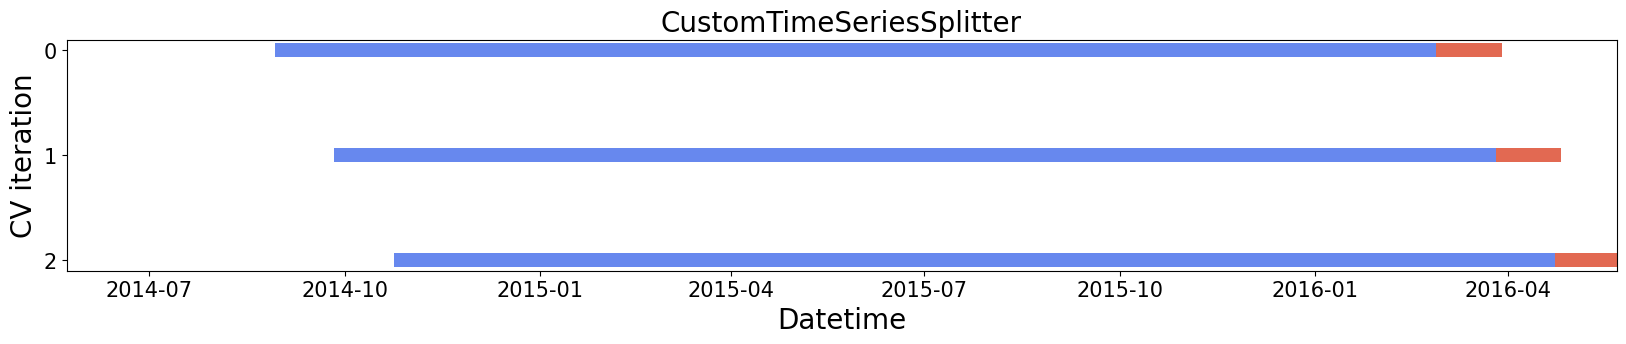

In [81]:
sample = data.iloc[::1000][[day_col, dt_col]].reset_index(drop=True)
show_cv_days(cv, sample, dt_col, day_col)
plot_cv_indices(cv, sample, dt_col)

del sample
gc.collect()

Here we define and visualize a custom time-series cross-validation strategy using CustomTimeSeriesSplitter, which we created in the last cell. The show_cv_days function displays the start, end, and duration of each train/test period, while plot_cv_indices provides a visual timeline of each split, helping ensure proper temporal order and preventing data leakage. This setup is ideal for validating models in forecasting tasks.

In [83]:
features = [
    # main features
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "snap_CA",
    "snap_TX",
    "snap_WI",
    "sell_price",
    # demand features
    "shift_t28",
    "shift_t29",
    "shift_t30",
    # std
    "rolling_std_t7",
    "rolling_std_t30",
    "rolling_std_t60",
    "rolling_std_t90",
    "rolling_std_t180",
    # mean
    "rolling_mean_t7",
    "rolling_mean_t30",
    "rolling_mean_t60",
    "rolling_mean_t90",
    "rolling_mean_t180",
    # min
    "rolling_min_t7",
    "rolling_min_t30",
    "rolling_min_t60",
    # max
    "rolling_max_t7",
    "rolling_max_t30",
    "rolling_max_t60",
    # dist features
    "rolling_skew_t30",
    "rolling_kurt_t30",
    # price features
    "price_change_t1",
    "price_change_t365",
    "rolling_price_std_t7",
    "rolling_price_std_t30",
    # time features
    "year",
    "quarter",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend",
]


is_train = data["d"] < 1914

X_train = data[is_train][[day_col] + features].reset_index(drop=True)
y_train = data[is_train]["demand"].reset_index(drop=True)
X_test = data[~is_train][features].reset_index(drop=True)

id_date = data[~is_train][["id", "date"]].reset_index(drop=True)

gc.collect()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (21434470, 46)
X_test shape: (853720, 45)


In this cell, we prepare the training and test datasets for our models, by defining whole list of features that we've created and splitting them appropriately.

Since we have done everything we needed, already have train and test datasets fully ready for the training, we can move to the next section.

## Model Training and Evaluation

Before we start with our baseline model, I want to prove that the traditional time series models are not that useful for this dataset by training SARIMA on one of the hierarchies.

In [88]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Test Statistic                  -20.626012
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    1885.000000
Critical Value (1%)              -3.433824
Critical Value (5%)              -2.863075
Critical Value (10%)             -2.567587
dtype: float64
Test Statistic                  -19.400488
p-value                           0.000000
#Lags Used                       23.000000
Number of Observations Used    1882.000000
Critical Value (1%)              -3.433829
Critical Value (5%)              -2.863077
Critical Value (10%)             -2.567588
dtype: float64
Test Statistic                  -19.739548
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    1879.000000
Critical Value (1%)              -3.433835
Critical Value (5%)              -2.863079
Critical Value (10%)             -2.567590
dtype: float64
Test RMSE: 685.5493506255094


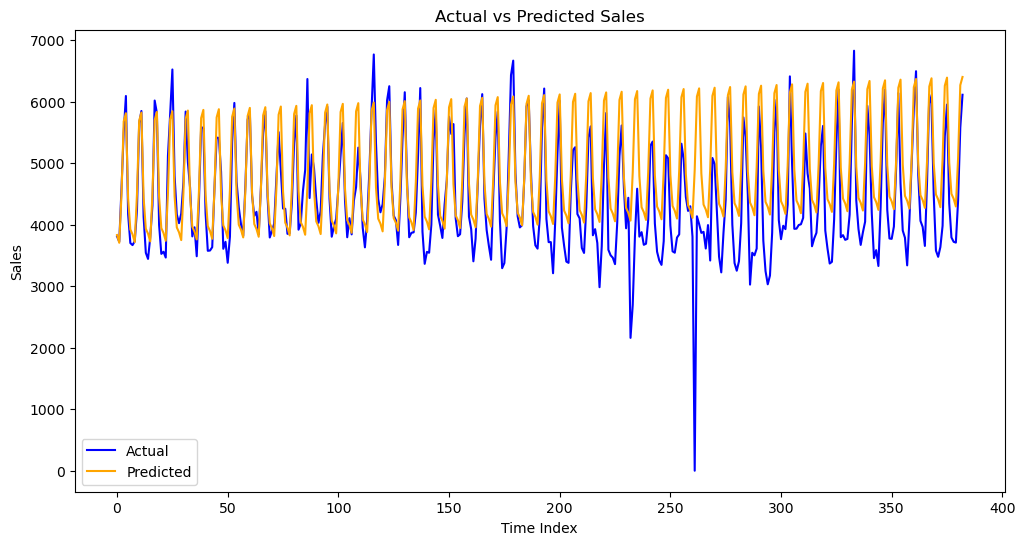

3800

In [89]:
sales_train_validation_s = pd.read_csv(r"C:\Users\user\Desktop\sales_train_validation.csv")
calendar_s = pd.read_csv(r"C:\Users\user\Desktop\calendar.csv")

store_level_s = sales_train_validation_s.groupby(sales_train_validation_s['store_id']).sum()
store_level_s['d'] = store_level_s.index

store_level_t_s = store_level_s.transpose()
store_level_t_s['d'] = store_level_t_s.index

store_level_final_s = store_level_t_s.merge(calendar_s, on='d')

store_level_final_s['date'] = store_level_final_s['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)

store_level_final_s['first_difference'] = store_level_final_s['CA_1'] - store_level_final_s['CA_1'].shift(1)
test_stationarity(store_level_final_s['first_difference'])

store_level_final_s['seasonal_difference'] = store_level_final_s['CA_1'] - store_level_final_s['CA_1'].shift(7)
test_stationarity(store_level_final_s['seasonal_difference'])

store_level_final_s['seasonal_first_difference'] = (
    store_level_final_s['CA_1'] - store_level_final_s['CA_1'].shift(1)
    - store_level_final_s['CA_1'].shift(7) + store_level_final_s['CA_1'].shift(8)
)
test_stationarity(store_level_final_s['seasonal_first_difference'])

train_size_s = int(len(store_level_final_s['CA_1']) * 0.8)
train_s = store_level_final_s['CA_1'][:train_size_s].astype(float).values
test_s = store_level_final_s['CA_1'][train_size_s:].astype(float).values

model_s = SARIMAX(train_s, order=(0, 1, 1), seasonal_order=(0, 1, 1, 7))
results_s = model_s.fit()

predictions_s = results_s.predict(start=len(train_s), end=len(train_s) + len(test_s) - 1)

rmse_s = np.sqrt(mean_squared_error(test_s, predictions_s))
print(f"Test RMSE: {rmse_s}")

plt.figure(figsize=(12, 6))
plt.plot(test_s, color='blue', label='Actual')
plt.plot(predictions_s, color='orange', label='Predicted')
plt.title("Actual vs Predicted Sales")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.show()

del sales_train_validation_s
del calendar_s
del store_level_s
del store_level_t_s
del store_level_final_s
del train_s
del test_s
del model_s
del results_s
del predictions_s
del rmse_s
gc.collect()

As we can see, SARIMA showed a high RMSE for a test dataset and on the plot it shows that even tho it can catch some seasonal patters, it is not really the best option for the noisy, fluctuative and non-linear patterns. 

Let's now move on with Random Forest as our baseline model.

In [91]:
def train_rf(rf_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]

        model = RandomForestRegressor(**rf_params)
        model.fit(X_trn.drop(drop_when_train, axis=1), y_trn)
        models.append(model)

        val_preds = model.predict(X_val.drop(drop_when_train, axis=1))
        print("Fold RMSE:", rmse(y_val, val_preds))

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models


rf_params = {
    "n_estimators": 20,
    "max_depth": 15,
    "n_jobs": -1,
    "random_state": 42,
    "verbose": 1,
}

cv_params = {
    "n_splits": 3,
    "train_days": int(365 * 1.5),
    "test_days": DAYS_PRED,
    "day_col": day_col,
}
cv = CustomTimeSeriesSplitter(**cv_params)

models = train_rf(rf_params, X_train, y_train, cv=cv, drop_when_train=[day_col])

gc.collect()

preds = np.zeros(X_test.shape[0])

for model in models:
    preds += model.predict(X_test)

preds = preds / cv.get_n_splits()


----- Fold: (1 / 3) -----



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 14.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 14.3min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished


Fold RMSE: 2.3688610585873375

----- Fold: (2 / 3) -----



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 13.7min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 13.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished


Fold RMSE: 2.28866505265975

----- Fold: (3 / 3) -----



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 13.0min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 13.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished


Fold RMSE: 2.138477250199683


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  18 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  20 out of  20 | elapsed:    0.1s finished


Since the training is done, time to check the feature importance, which we will discuss in the very last section of this project - Business Perspective.

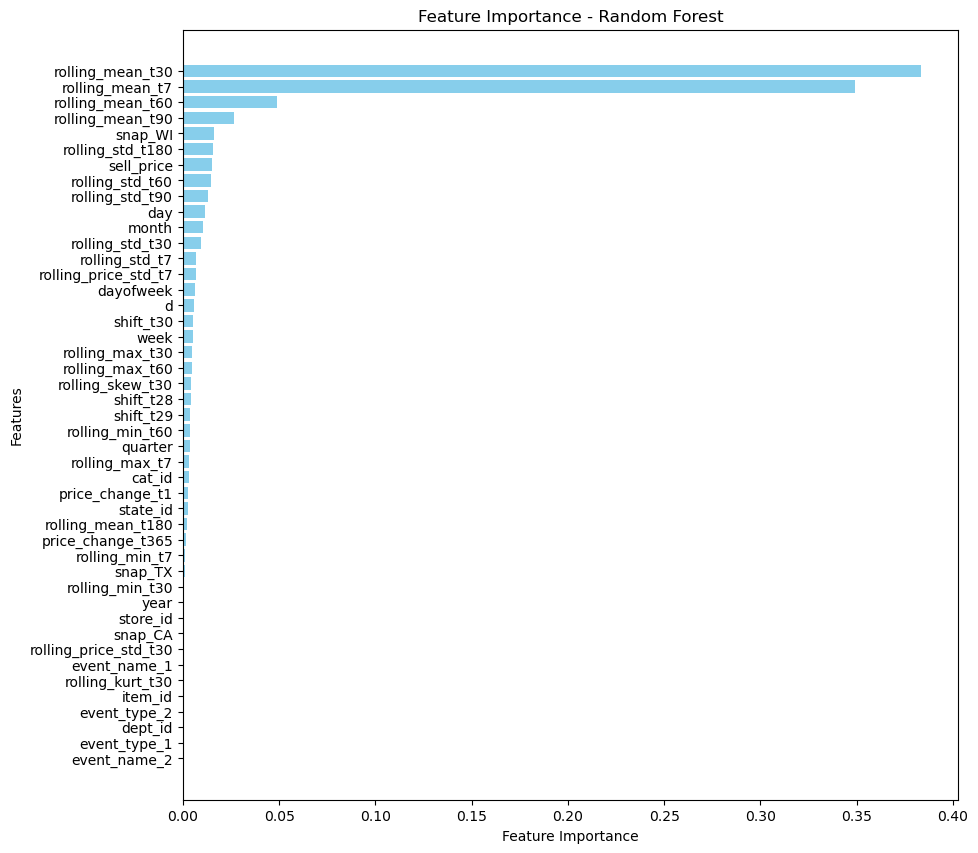

In [93]:
def plot_feature_importance(models, feature_names):
    importances = np.mean([model.feature_importances_ for model in models], axis=0)
    
    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    sorted_features = np.array(feature_names)[sorted_idx]
    
    plt.figure(figsize=(10, 10))
    plt.barh(sorted_features, sorted_importances, color="skyblue")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title("Feature Importance - Random Forest")
    plt.gca().invert_yaxis()  
    plt.show()

plot_feature_importance(models, X_train.columns)

In [94]:
def make_submission(test, submission):
    test = test.copy()
    test["demand"] = preds

    preds_df = test[["id", "date", "demand"]]
    preds_df = preds_df.pivot(index="id", columns="date", values="demand").reset_index()
    preds_df.columns = ["id"] + ["F" + str(d + 1) for d in range(DAYS_PRED)]

    vals = submission[["id"]].merge(preds_df, how="inner", on="id")
    evals = submission[submission["id"].str.endswith("evaluation")]
    final = pd.concat([vals, evals])

    assert final.drop("id", axis=1).isnull().sum().sum() == 0
    assert final["id"].equals(submission["id"])

    final.to_csv("rf_submission.csv", index=False)

make_submission(id_date.assign(demand=preds), submission)

In [95]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n----- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) -----\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(
            X_trn.drop(drop_when_train, axis=1),
            label=y_trn,
            categorical_feature=["item_id"],
        )
        val_set = lgb.Dataset(
            X_val.drop(drop_when_train, axis=1),
            label=y_val,
            categorical_feature=["item_id"],
        )

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            num_boost_round=fit_params["num_boost_round"],  
            callbacks=[
                lgb.early_stopping(stopping_rounds=fit_params["early_stopping_rounds"]),
                lgb.log_evaluation(fit_params["verbose_eval"]),
            ],  
        )
        models.append(model)

        gc.collect()

    return models

In [96]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "objective": "regression",
    "n_jobs": -1,
    "seed": 42,
    "learning_rate": 0.1,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

models = train_lgb(
    bst_params, fit_params, X_train, y_train, cv, drop_when_train=[day_col]
)

gc.collect()

lgb_preds = np.zeros(X_test.shape[0])

for model in models:
    lgb_preds += model.predict(X_test)

lgb_preds = lgb_preds / cv.get_n_splits()


----- Fold: (1 / 3) -----

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.672408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8123
[LightGBM] [Info] Number of data points in the train set: 16678030, number of used features: 45
[LightGBM] [Info] Start training from score 1.221132
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.14983	valid's rmse: 2.36898
Early stopping, best iteration is:
[58]	train's rmse: 2.19757	valid's rmse: 2.35998

----- Fold: (2 / 3) -----

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[Light

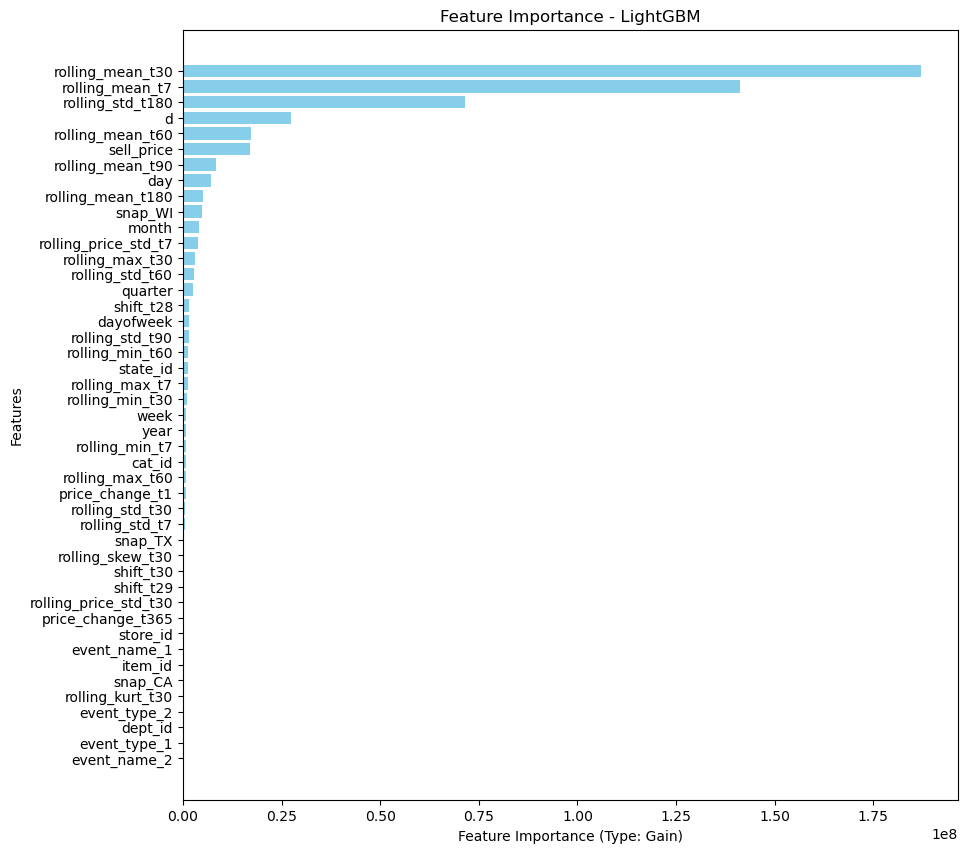

In [97]:
def plot_lgb_feature_importance(models, feature_names, importance_type="split"):
    importances = np.mean([model.feature_importance(importance_type) for model in models], axis=0)
    
    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = importances[sorted_idx]
    sorted_features = np.array(feature_names)[sorted_idx]
    
    plt.figure(figsize=(10, 10))
    plt.barh(sorted_features, sorted_importances, color="skyblue")
    plt.xlabel("Feature Importance (Type: " + importance_type.capitalize() + ")")
    plt.ylabel("Features")
    plt.title("Feature Importance - LightGBM")
    plt.gca().invert_yaxis()
    plt.show()

plot_lgb_feature_importance(models, X_train.columns, importance_type="gain")

In [98]:
def make_submission(test, submission):
    test = test.copy()
    test["demand"] = preds

    preds_df = test[["id", "date", "demand"]]
    preds_df = preds_df.pivot(index="id", columns="date", values="demand").reset_index()
    preds_df.columns = ["id"] + ["F" + str(d + 1) for d in range(DAYS_PRED)]

    vals = submission[["id"]].merge(preds_df, how="inner", on="id")
    evals = submission[submission["id"].str.endswith("evaluation")]
    final = pd.concat([vals, evals])

    assert final.drop("id", axis=1).isnull().sum().sum() == 0
    assert final["id"].equals(submission["id"])

    final.to_csv("lightgbm_submission.csv", index=False)
    
make_submission(id_date.assign(demand=preds), submission)

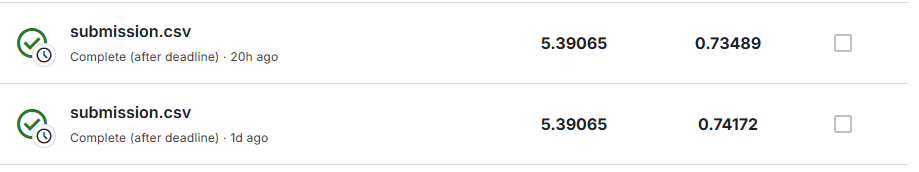

Here are the final submissions from the competition: the LightGBM model (first) and the Random Forest model (second). Both performed quite well, with the Random Forest achieving a public score of 0.74172 and the LightGBM slightly ahead at 0.73489. These results placed us within the top 15% out of nearly 5,600 participants worldwide.

I am confident that with more time, I could have achieved significantly better scores. The main limitation was the time constraint, especially considering the size of the dataset and the lengthy training times—both models took several hours to train. Given more time, I would have further tuned the LightGBM model and explored additional models and variations.

Despite these constraints, I am satisfied with the current results and look forward to refining and improving my approach in future competitions without such limitations.

## Business Perspective

Now let's talk about this project from a business's point of view. Walmart is a large retailer company that operates with thin margins and high sales volume. The primary businesss metrics relevant to this project could be the following:

- **Revenue**: Walmart tracks overall revenue at multiple levels: per store, per state, per product category, and overall. This metric is really a basic yet very important for retailer companies.

- **Gross Margin**: Gross margin is a key business metric, as Walmart relies on predicting demand to price items correctly and manage inventory costs.

- **Inventory Turnover**: This one also must be tracked in my opinion by Walmart's business team. It measures how efficiently inventory is used. High inventory turnover maximizes revenue while avoiding storage costs and obsolescence.

- **Stock-out Rate (Lost Sales)**: Percentage of items unavailable (out of stock) when customers try to purchase them. Forecasting demand prevents stock-outs.

- **Overstocking Costs**: Holding extra inventory results in higher warehousing costs, spoilage, and lost capital, so it's essential to predict demand accurately.

- **Sales per Square Foot (Store Efficiency)**: I think this one is one of the most important ones too, especially relevant to compare performance across stores of varying sizes.

- **Customer Satisfaction**: This one is a little bit general and harder to track metric, but really important to keep loyal customers shopping at Walmart.

- **SNAP-Specific Metrics**: For states where SNAP applies, Walmart may monitor how SNAP affects sales trends and revenue, as SNAP may cause temporary spikes in specific product categories.

Besides this general useful metrics, that I think Walmart could use track to improve their performance on market, let's also talk more our case scenario and say how our forecast improves these business metrics:

- **Revenue & Customer Satisfaction**: Accurate demand forecasting ensures that goods are available when customers shop. Meeting demand helps maintain customer satisfaction, loyalty, and overall revenue.

- **Inventory Turnover**: Overstocking reduces inventory turnover, gathering up financial resources. Forecasting avoids overstock through precise demand planning.

- **Stock-Out Rate & Lost Sales**: Avoiding understock situations ensures sales aren’t lost to competitors. Accurate predictions minimize stock-out rates.

- **Gross Margin Optimization**: Forecasting allows adjustments in pricing strategies, markdown management, and promotions to maximize gross margins.

- **Overstock Costs**: Accurate forecasting avoids excess inventory, which reduces carrying costs and avoids wastage for perishables.

- **SNAP Demand Trends**: Forecasting adjusts supply plans for products heavily bought by SNAP users. Walmart can adjust its stocking policies to match periodic demand spikes.

The metrics that we've just overviewed was more of a financial side, for business teams, now let's talk about more technical - data science, side:

So in competitions, machine learning models are often evaluated using general-purpose metrics like Root Mean Squared Error (RMSE). While RMSE is useful from a technical standpoint — measuring how close the predicted values are to the actual ones — it doesn’t always align with business objectives. RMSE simply penalizes large errors more than small ones, but it treats all products and errors equally. This is a limitation when applying it to a business like Walmart. For instance, incorrectly predicting sales of a high-margin item like a television has a much bigger financial impact than an error on low-cost items like bread. Yet, RMSE considers them the same. This can lead to model optimizations that don’t reflect Walmart’s actual priorities — such as revenue, profit, or customer satisfaction.

Let's say better metrics that are more aligned for this business problem:

1. Weighted RMSE

Instead of treating all items equally, this metric gives more importance to products that contribute more to revenue. That way, the model is encouraged to be more accurate on high-value items. This is more aligned with business interests, as it prioritizes accuracy where financial impact is greatest.

2. Stock-Out Penalizing Loss

This metric recognizes that under-predicting demand (leading to stock-outs) is often worse than over-predicting. Stock-outs can mean lost sales, unhappy customers, and damaged brand reputation. By penalizing under-forecasting more heavily, the model learns to avoid these situations, which helps maintain customer satisfaction and revenue.

3. Inventory Cost-Aware Error

This metric tries to balance the cost of overstocking and understocking. Overstocking leads to higher storage and potential waste, while understocking results in missed sales. By embedding these real costs into the metric, the model can make smarter trade-offs that reflect actual operational challenges, improving overall efficiency and profitability.

4. Mean Weighted Absolute Percentage Error (MWAPE)

This is a more flexible alternative that focuses on percentage errors while giving more weight to high-selling or high-revenue products. It's useful for businesses because it highlights relative accuracy while still emphasizing the products that matter most financially.

This metrics are little bit trickier to implement for our case scenario, but we are talking more generally, so if implemented, this few metrics could tell lot more to a data science team, and merit the company in a more convinient and simpler ways.

Feature Importance plays a big role for a decision-making process. We have LightGBM's feature importance in our hands and let's analyze it and speak from the business perspective:

**Rolling Averages and Standard Deviations**

- **Short and Medium Term Trends**  
  The 30-day and 7-day rolling means (rolling_mean_t30, rolling_mean_t7) were the most influential features. These capture:
  - Daily and weekly sales momentum.
  - Emerging trends at the SKU level.

- **Sales Volatility Awareness**  
  The 180-day rolling standard deviation (rolling_std_t180) shows historical fluctuations in demand. This allows Walmart to:
  - Conservatively stock high-volatility items to reduce risk of stock-outs or overstock.
  - Aggressively stock low-variance items with leaner inventory levels.

- **Strategic Action**  
  Tailor inventory strategy:
  - High-variance - buffer stock or demand smoothing.
  - Low-variance - lean inventory, faster turnover.


**Seasonality and Time-Based Features**

- Time Features like month, day, and week were important, revealing seasonal buying behavior.

- Holiday Sensitivity 
  Certain products (party supplies, decorations) experience spikes during:
  - Christmas, Black Friday, Mother’s Day, etc.

- Actionable Moves  
  Walmart can:
  - Schedule targeted marketing campaigns.
  - Allocate temporary labor to regions with seasonal surges.


**Price and Elasticity Features**

- Key Features: sell_price, price_change_t1, and similar metrics.

- Revenue Optimization 
  Walmart can:
  - Analyze price elasticity to find which products are sensitive to price.
  - Implement dynamic pricing strategies for revenue maximization.


**Rolling Trends Across Longer Timeframes**

- Long-Term Features: rolling_mean_t180, rolling_std_t60.

- Business Use Cases:
  - Spot products with sustained popularity for stocking priority.
  - Flag underperforming categories that may benefit from promotions or replacements.


**Event-Based and Regional Features**

- Localized Demand 
  Features like snap_WI, event_type_1, and state_id reflect:
  - Region-specific SNAP participation (Wisconsin).
  - Demand changes driven by events or holidays.

- **Implications**:
  - Stock more SNAP-eligible items in high-SNAP areas.
  - Align inventory and marketing around local events (sports games, Mother's Day).

So we talked about all the objectives, technical and non-technical metrics that was used and could have been used in other cases, now let's talk about how those metrics could help business teams for decision-making:

 **1. Variables Walmart Can Control**

- **Prices**  
  Walmart can modify product prices based on demand forecasts to optimize revenue. For example, they might:
  - Reduce prices during periods of low demand.
  - Adjust prices near stock exhaustion to increase turnover.

- **Promotions and Discounts**  
  Offering strategic discounts on overstocked items (especially regionally) can help clear inventory when demand is forecasted to be low.

- **Inventory Decisions**  
  Forecasts allow Walmart to:
  - Fine-tune ordering quantities.
  - Avoid overstock (waste/storage cost) and understock (lost sales).

- **Advertising Spend**  
  Advertising can be increased or optimized:
  - In locations where projected demand is low.
  - For products/categories that need a visibility boost.


 **2. Variables Walmart Cannot Control**

- **External Factors**  
  Elements outside Walmart’s control that influence demand include:
  - Weather conditions (water sales spike before hurricanes).
  - National holidays or events.
  - Macroeconomic trends (inflation, recession).

- **Customer Preferences**  
  Shifts in consumer taste and loyalty, such as:
  - Preference for competitor brands.
  - Changes in dietary, cultural, or ethical buying habits.


 **3. Strategic Decisions Walmart Can Make with the Model**

- **Optimize Replenishment**  
  Use accurate forecasts to:
  - Adjust store-level inventory.
  - Avoid delays and stock-outs.

- **Adjust Pricing Based on Elasticity**  
  Implement dynamic pricing strategies, such as:
  - Increasing prices for inelastic goods during high demand.
  - Offering promotions on elastic goods during slow periods.

- **Category-Wise Planning**  
  Allocate resources more effectively by:
  - Identifying underperforming categories for reevaluation.
  - Expanding shelf space for consistently high-performing items.

In [107]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,part,date,...,price_change_t365,rolling_price_std_t7,rolling_price_std_t30,year,quarter,month,day,dayofweek,week,is_weekend
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,1211,1,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,23,4,21,0
20334,FOODS_2_214_TX_3_validation,428,1,0,6,1,1211,0,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,23,4,21,0
20333,FOODS_2_213_TX_3_validation,427,1,0,6,1,1211,0,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,23,4,21,0
20332,FOODS_2_212_TX_3_validation,426,1,0,6,1,1211,0,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,23,4,21,0
20331,FOODS_2_211_TX_3_validation,425,1,0,6,1,1211,0,train,2014-05-23,...,NaN,NaN,NaN,2014,2,5,23,4,21,0


**Price Elasticity of Demand (PED)** is a way to measure how much the demand for a product changes when its price changes.

If a small change in price causes a big change in how much people buy, we say the product is price elastic. For example, if the price of a soft drink goes up, people might quickly buy less or switch to another brand.

If the demand stays nearly the same even after the price changes, the product is price inelastic. 

Let’s say Walmart wants to analyze the demand for one of its products:

**Step 1: Measure Sensitivity**

They observe sales data over time and notice that when the price of this detergent increases by $1, the number of units sold drops significantly. This tells them the product is price elastic—customers are sensitive to price changes and might switch to another brand or store.

**Step 2: Business Decisions Based on PED**

Pricing Strategy: Since the detergent is price elastic, Walmart might avoid raising the price too much. Instead, they could lower it slightly to attract more buyers and increase total sales.

Promotions: Walmart could run regular discounts or bundle offers, knowing that even small price cuts could boost demand and drive traffic to the store.

Supplier Negotiations: If Walmart knows that customers are price-sensitive for this product, they might push the supplier for lower wholesale prices, allowing Walmart to stay competitive without cutting into profits.

Inventory Planning: During promotional periods, Walmart can stock up, anticipating a sharp rise in demand due to the product's elasticity.

In [109]:
df = reduce_mem_usage(data)
product_id = "HOBBIES_1_001_CA_1_validation"
product_df = df[df["id"] == product_id]

product_df = product_df[(product_df["demand"] > 0) & (product_df["sell_price"] > 0)]

product_df["log_price"] = np.log(product_df["sell_price"])
product_df["log_demand"] = np.log(product_df["demand"])

slope, intercept, r_value, p_value, std_err = linregress(
    product_df["log_price"], product_df["log_demand"]
)

price_elasticity = slope 

print(f"Estimated price elasticity for {product_id}: {price_elasticity:.2f}")

Estimated price elasticity for HOBBIES_1_001_CA_1_validation: -2.02


In [110]:
store_elasticities = []

for store_id, store_df in data.groupby("store_id"):
    store_df = store_df[(store_df["demand"] > 0) & (store_df["sell_price"] > 0)]
    
    if store_df["sell_price"].nunique() > 1 and len(store_df) > 30:
        store_df["log_price"] = np.log(store_df["sell_price"])
        store_df["log_demand"] = np.log(store_df["demand"])

        try:
            slope, *_ = linregress(store_df["log_price"], store_df["log_demand"])
            store_elasticities.append({"store_id": store_id, "elasticity": slope})
        except ValueError:
            continue

store_elasticity_df = pd.DataFrame(store_elasticities)
store_elasticity_df

,store_id,elasticity
0,0,-0.363365
1,1,-0.295157
2,2,-0.378001
3,3,-0.301862
4,4,-0.323756
5,5,-0.322010
6,6,-0.313335
7,7,-0.352450
8,8,-0.402976
9,9,-0.375405


Let's discuss this results with business implications. First, we calculated the price elasticity of demand for a single product—HOBBIES_1_001_CA_1, and found it to be approximately -2.02. This indicates a highly elastic demand: a 1% increase in price leads to roughly a 2% drop in quantity demanded. Customers for this product are very sensitive to price changes, likely switching brands or postponing purchases if prices rise. Walmart should consider this when pricing such products to avoid losing significant sales volume.

Now let's check the store aggregated elastisities and discuss the implications of the first 3 stores as an example: 

- Store 0 (-0.36): Demand is relatively inelastic. Price changes have a moderate effect on sales volume. Walmart can afford small price increases here without losing many customers, helping increase margin.

- Store 1 (-0.30): Even less sensitive. Customers here are less price-conscious, perhaps due to limited local competition or brand loyalty. Walmart might focus less on aggressive price promotions and more on maintaining consistent pricing or bundling to maximize profit.

- Store 2 (-0.38): Slightly more sensitive but still inelastic. Walmart can use moderate discounts strategically to boost volume during key periods (holidays, weekends) without hurting profits too much.


How Walmart can use these insights:

- Tailored Pricing Strategies: Instead of applying uniform price changes across all stores, Walmart can customize pricing by store elasticity. For example, stores with more elastic demand might benefit from more frequent discounts or competitive pricing, while inelastic stores might sustain higher prices.

- Promotion Optimization: Stores with higher elasticity (closer to -1 or beyond) can run promotions to stimulate sales more effectively. For stores with low elasticity, promotions might focus on upselling or cross-selling rather than price cuts.

- Inventory Planning: Understanding elasticity helps Walmart forecast how sales volume responds to price changes. In stores with elastic demand, stock levels can be adjusted to meet spikes during price promotions, avoiding stockouts or excess inventory.

- Supplier Negotiations and Cost Control: If demand is elastic, Walmart must maintain competitive prices to avoid losing customers, so negotiating better wholesale costs becomes critical. For inelastic stores, Walmart has more flexibility in pricing and margin management.

In [112]:
df["snap_active"] = (
    (df["snap_CA"] + df["snap_TX"] + df["snap_WI"]) > 0
).astype(int)

naive_snap_effect = df.groupby("snap_active")["demand"].mean()
print("Naive SNAP demand:\n", naive_snap_effect)

Naive SNAP demand:
 snap_active
0    1.138703
1    1.245671
Name: demand, dtype: float64


In [113]:
model_df = df[["demand", "sell_price", "snap_active"]].copy()
model_df = model_df[(model_df["demand"] > 0) & (model_df["sell_price"] > 0)]

model_df["log_price"] = np.log(model_df["sell_price"])
X = model_df[["log_price", "snap_active"]]
X = sm.add_constant(X)
y = np.log(model_df["demand"])

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 demand   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                 4.592e+05
Date:                Mon, 30 Jun 2025   Prob (F-statistic):               0.00
Time:                        20:32:43   Log-Likelihood:            -9.5697e+06
No. Observations:             8223297   AIC:                         1.914e+07
Df Residuals:                 8223294   BIC:                         1.914e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0808      0.001   1979.110      

**Discussion of SNAP Impact on Demand**

We analyzed the effect of SNAP (Supplemental Nutrition Assistance Program) activity on product demand using an Ordinary Least Squares (OLS) regression. The key results from the model are:

Coefficient for snap_active: +0.0379 (significant at p < 0.001)

Coefficient for log_price: -0.3421 (also significant)

Intercept (constant): 1.0808

R-squared: 0.10, indicating that 10% of demand variation is explained by price and SNAP activity combined.

What Does This Mean? The positive coefficient for snap_active (0.0379) means that when SNAP benefits are active, demand increases by roughly 3.8% on average (since the model is in log-linear form). This suggests that SNAP participation modestly boosts demand, likely by increasing consumers’ purchasing power.

The negative price coefficient (-0.3421) aligns with expectations: higher prices reduce demand, consistent with typical price elasticity findings.

The R-squared of 0.10 shows that while price and SNAP status explain some variation in demand, other factors (seasonality, promotions, store location, etc.) also play a big role.

**Business Implications for Walmart**

- Planning and Inventory Management

SNAP-active periods or areas with high SNAP participation should anticipate slightly increased demand. Walmart can adjust inventory to ensure availability and avoid stockouts, especially on staple items frequently purchased by SNAP recipients.

- Targeted Marketing and Promotions

Knowing that SNAP participation drives demand, Walmart could design marketing strategies or promotions aligned with SNAP benefit schedules to maximize sales during those times.

- Pricing Strategy

Since SNAP boosts demand, Walmart could evaluate whether modest price adjustments during SNAP-active periods might increase overall revenue without harming affordability for SNAP recipients.

- Store Location and Assortment Decisions

Walmart can use SNAP participation data to optimize product assortments in stores located in areas with high SNAP activity, ensuring products that benefit from SNAP-driven demand are well stocked.